# Week 2 - Function 2 ((11DP, 2D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [2]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils.plotting_utils import (
    plot_2D_initial_data,
    plot_output_outliers,
    plot_2D_mean_uncertainty,
)

# Plan
We now have ((11, 2)) - 11DP & 2D that can be found `./data/week_1/function_2/`.

0. Setup:
    1. Load new data and previous week data
    2. Compare normalise data plot
    3. Early result
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [3]:
X_train_raw = np.load(r"./data/week_2/function_2/inputs.npy")
y_train_raw = np.load(r"./data/week_2/function_2/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(11, 2), y=(11,)
X range: [0.0287, 0.9266]
y range: [-6.56e-02, 6.11e-01]


# 0.2. Setup > Analyse raw data

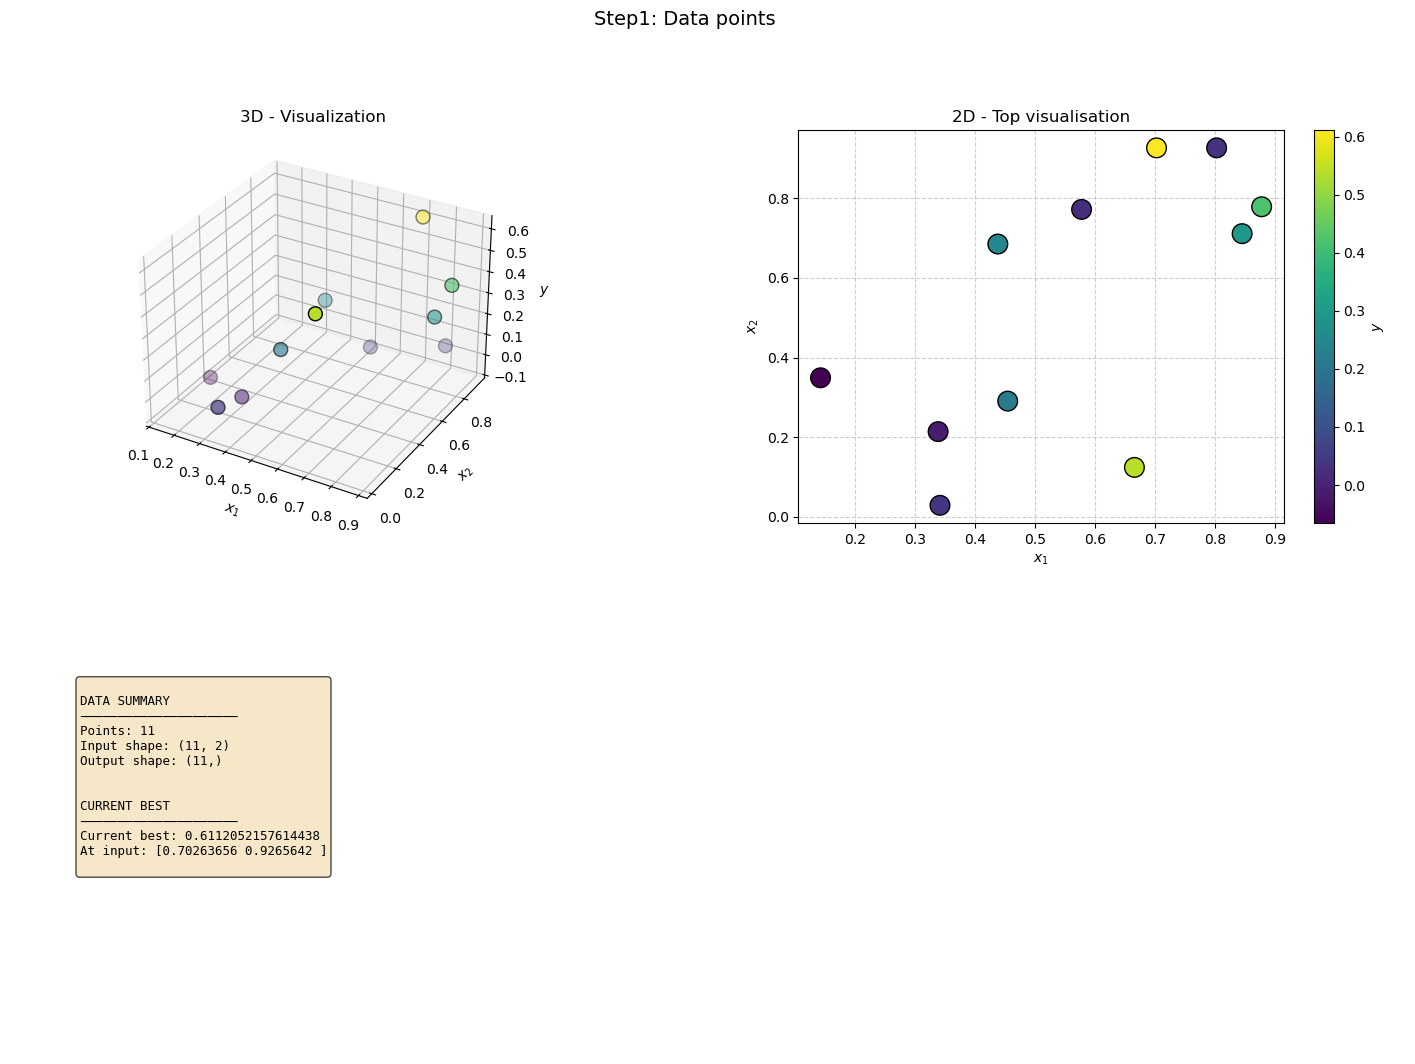

In [11]:
plot_2D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 0.3. Setup > Normalise the data

In [12]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

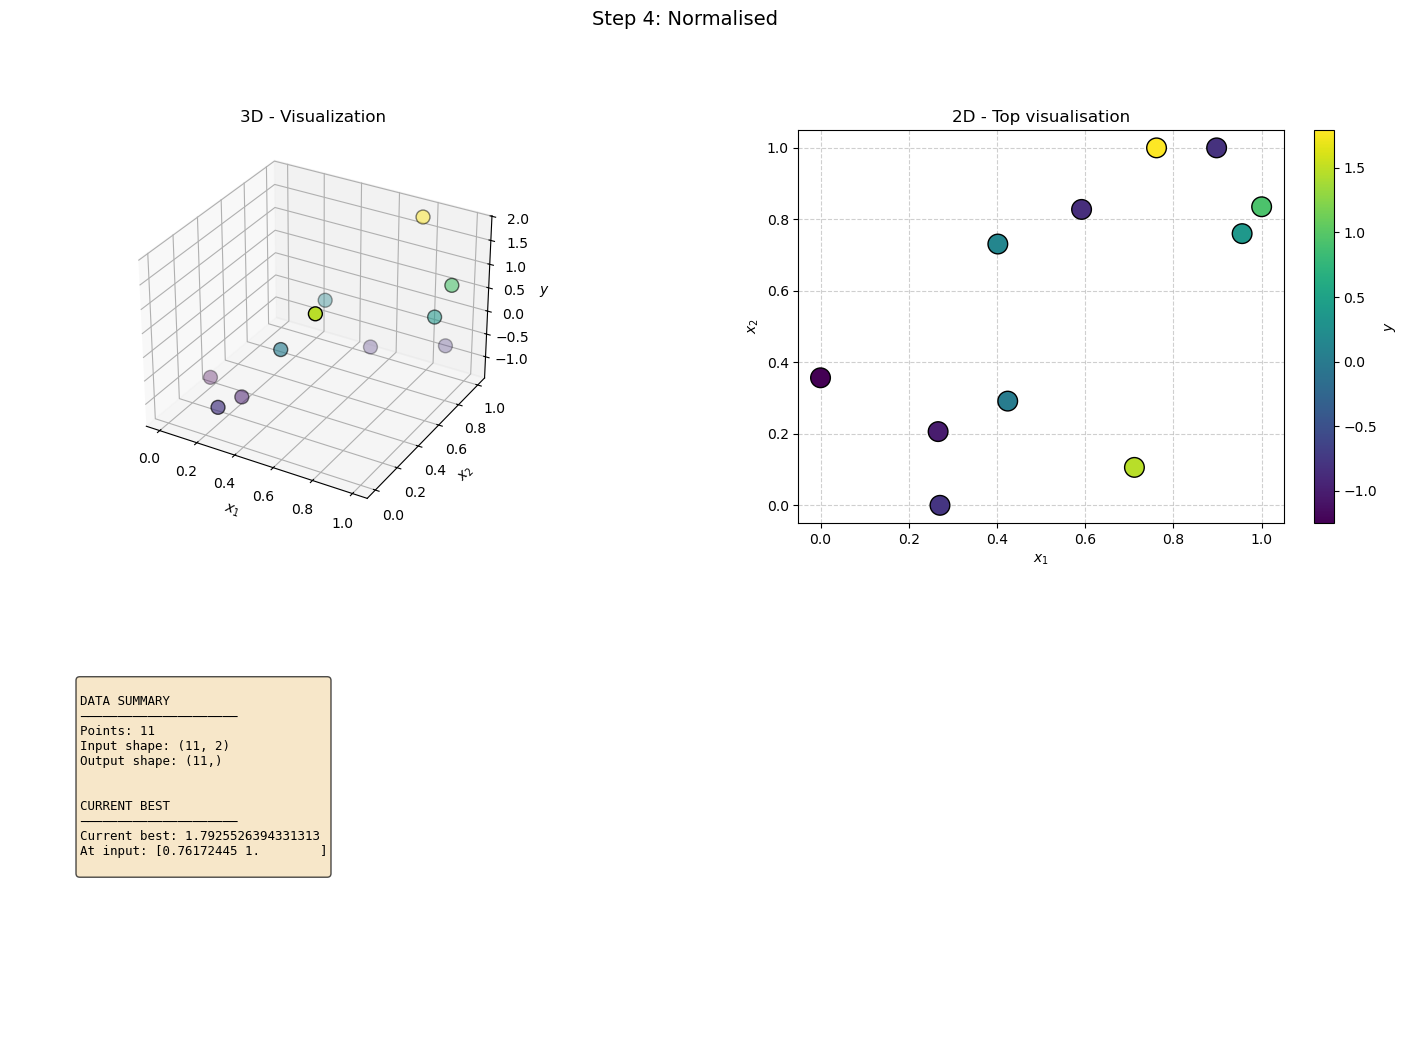

In [13]:
plot_2D_initial_data(X_train, y_train, "Step 4: Normalised", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train)}
Input shape: {X_train.shape}
Output shape: {y_train.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train)}
At input: {X_train[np.argmax(y_train)]}
""")

# 0.5. Setup > Early result

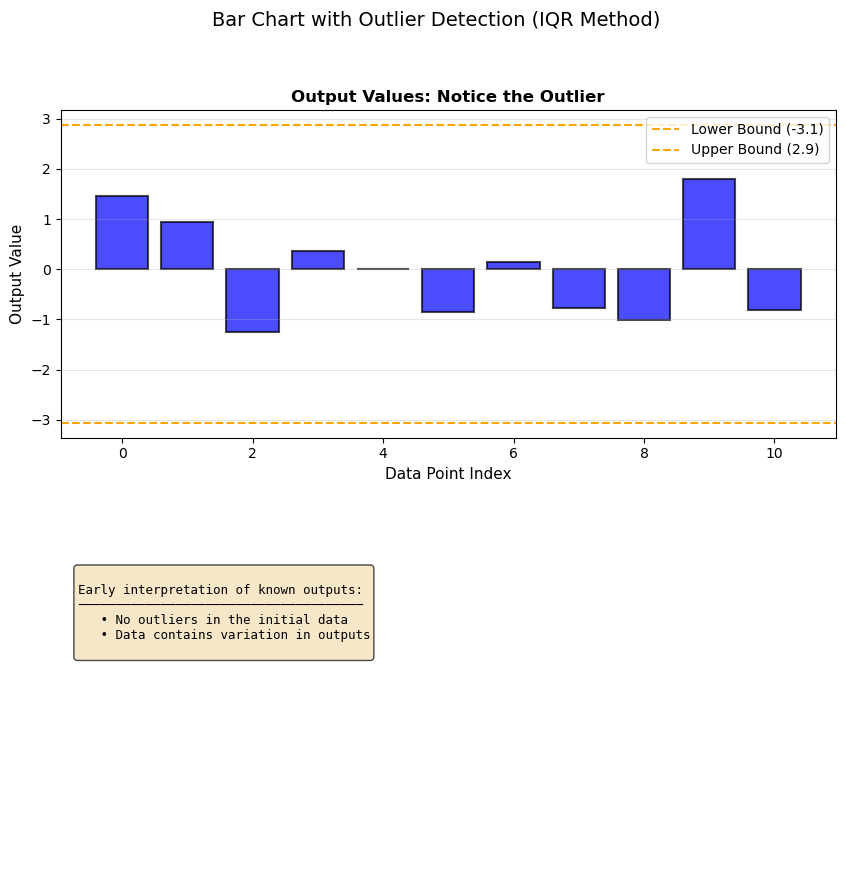

In [14]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • No outliers in the initial data
   • Data contains variation in outputs
""")

# 1. Build probabilistic Model

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs

## Kernel choice
I don't see anything concerning with the different outputs so in this case I will use a RBF.

Optimized Kernel: 0.998**2 * RBF(length_scale=0.0487)


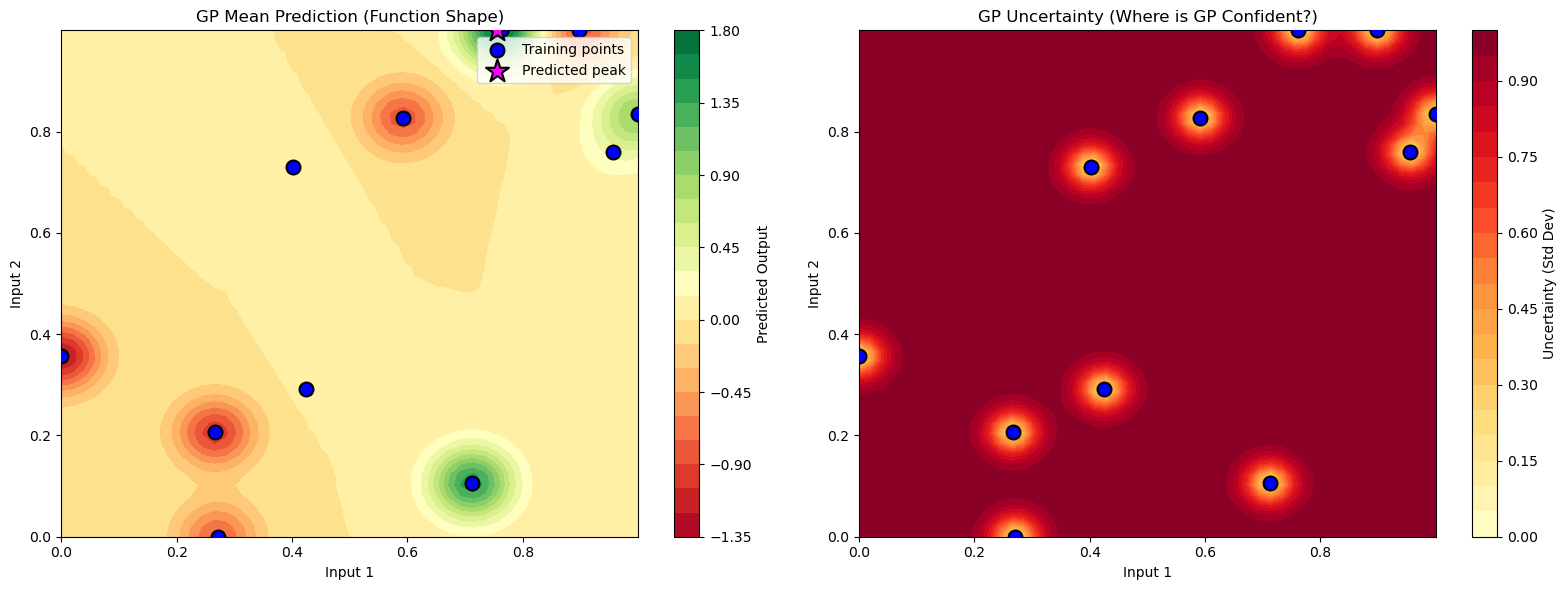

In [15]:
# Step 1: Kernel + Model
# ======================
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(
    length_scale=1.0,
    length_scale_bounds=(1e-9, 1e2)
)

model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=False,
    n_restarts_optimizer=10
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")


#  Create prediction grid
n_grid = 50
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)

X1_test, X2_test = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)

plot_2D_mean_uncertainty(
   X_train,
   X1_test,
   X2_test,
   mu,
   sigma,
)


# 2. Acquisition function

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs
- Low dimension

So in this case we want to explore to build an image of the function. So let's us Upper Confidence Bound for now since we want to do more exploration of the function.

In [16]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    
    UCB = mean + kappa * std
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation
    kappa : exploration parameter (higher = more exploration)
    """
    return mu + kappa * sigma


ucb_values = upper_confidence_bound(mu, sigma, kappa=10.0)

print(f"\nExpected Improvement (UCB):")
print(f"  Min: {ucb_values.min():.8f}")
print(f"  Max: {ucb_values.max():.8f}")
print(f"  Mean: {ucb_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ucb_values)
x_next_norm = X_grid[best_idx]
ei_best = ucb_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")

print(f"UCB Range: {ucb_values.min():.4f} to {ucb_values.max():.4f}")


Expected Improvement (UCB):
  Min: -0.80605004
  Max: 10.14257542
  Mean: 9.57876544

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.637760
  Input 2: 0.908240

In normalized space:
  Input 1: 0.673469
  Input 2: 0.979591

Predicted output at this point:
  Normalized: 0.320199 ± 0.982238
  Original: 0.283739
  95% CI: [-1.641446, 2.208925]

Expected Improvement at this point: 10.14257542
UCB Range: -0.8061 to 10.1426
